# Bounding configuration GP example

This notebook is designed to test whether a simple simple comprised of bounding boxes can be generated using [deap](http://deap.readthedocs.io/en/master/api/tools.html), a Python Evolutionary Algorithm Package.

In [1]:
import copy

import numpy as np

from functools import partial
import types

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from IPython.display import Image

In [2]:
# def progn(*args):
#     for arg in args:
#         arg()

# def prog2(out1, out2): 
#     return partial(progn,out1,out2)

# def prog3(out1, out2, out3):     
#     return partial(progn,out1,out2,out3)

# def if_then_else(condition, out1, out2):
#     out1() if condition() else out2()



In [3]:
from OCC.gp import gp_Pnt
from OCC.gp import gp_Ax2, gp_Ax1, gp_Dir
from OCC.BRepPrimAPI import BRepPrimAPI_MakeBox, BRepPrimAPI_MakeSphere

from airconics.base import AirconicsShape, AirconicsCollection
from airconics import Topology
from airconics.examples.wing_example_transonic_airliner import *
from airconics.examples.tailplane_example_transonic_airliner import *
from airconics.examples.straight_wing import *
from airconics import AirCONICStools as act

import pydot
import types
import functools
from collections import OrderedDict


# Create a simple Box class that inherits from AirconicsShape
#  - this will behave similarly to the Engine, Fuselage class etc.
class Box(AirconicsShape):
    def __init__(self, xmin, ymin, zmin, dx, dy, dz):
        # This implicitly calls build
        super(Box, self).__init__(construct_geometry=True,
                                             xmin=xmin,
                                             ymin=ymin,
                                             zmin=zmin,
                                             dx=dx,
                                             dy=dy,
                                             dz=dz)
        
        
        bbox_xmin, bbox_ymin, bbox_zmin, bbox_xmax, bbox_ymax, bbox_zmax = self.Extents()
        self.bbox_xmin = bbox_xmin
        self.bbox_ymin = bbox_ymin
        self.bbox_zmin = bbox_zmin
        self.bbox_xmax = bbox_xmax
        self.bbox_ymax = bbox_ymax
        self.bbox_zmax = bbox_zmax
        
        directions = []
        
    def Build(self):
        Xmin = gp_Pnt(self.xmin, self.ymin, self.zmin)
        Xmax = gp_Pnt(self.xmin + self.dx, self.ymin + self.dy, self.zmin + self.dz)
        self['Box'] = BRepPrimAPI_MakeBox(Xmin, Xmax).Shape()

# Create a simple Box class that inherits from AirconicsShape
#  - this will behave similarly to the Engine, Fuselage class etc.
class Sphere(AirconicsShape):
    def __init__(self, xcenter, ycenter, zcenter, d):
        # This implicitly calls build
        super(Sphere, self).__init__(construct_geometry=True,
                                             xcenter=xcenter,
                                             ycenter=ycenter,
                                             zcenter=zcenter,
                                             d=d)
        
        bbox_xmin, bbox_ymin, bbox_zmin, bbox_xmax, bbox_ymax, bbox_zmax = self.Extents()
        self.bbox_xmin = bbox_xmin
        self.bbox_ymin = bbox_ymin
        self.bbox_zmin = bbox_zmin
        self.bbox_xmax = bbox_xmax
        self.bbox_ymax = bbox_ymax
        self.bbox_zmax = bbox_zmax
        
    def Build(self):
        Xcenter = gp_Pnt(self.xcenter, self.ycenter, self.zcenter)
        self['Sphere'] = BRepPrimAPI_MakeSphere(Xcenter, self.d/2).Shape()


        
# # This dictionary will be used for topology tree formatting
# FUNCTIONS = {'E': Fuselage,         # E = Enclosure
#              'L': LiftingSurface,   # L = Lifting Surface
#              'P': Engine,           # P = Propulsion
#              '|': gp_Ax2,           # M = Mirror Plane
#              'B': Box,
#              '': None,
#              'C': Sphere}

# # Reversed dictionary for manually adding shapes, i.e. converting
# #  a class instance to a string
# FUNCTIONS_INV = {func: name for name, func in FUNCTIONS.items()}

# # The shapes of nodes in the exported graph from Topo class:
# NODE_PROPERTIES = {Fuselage: {'shape': 'ellipse', 'fill':'#136ed4'},
#           LiftingSurface: {'shape': 'box','fill':'#136ed4'},
#           Engine: {'shape': 'hexagon', 'fill':'#136ed4'},
#           gp_Ax2: {''},         # variables here are not used: mirror is a special case
#           Box: {'shape': 'box', 'fill':'#136ed4'},
#           types.NoneType : {'shape': 'point'},
#           float: {'shape': 'ellipse'},
#           int: {'shape': 'ellipse'},
#           Sphere: {'shape': 'circle', 'fill':'#136ed4'}}

###################################################################################
# Some trickery is needed to automatically define the BoxLayout functions for generating
# nodes with up to a defined number of attachments :
# def autodefine_functions(cls):
#     for comptype in cls.component_types:
#         for i in range(cls.max_attachments + 1):
#             name = comptype.__name__.lower()
#             print(name)
#             def partial_methodi(self, *args, **kwargs):
#                 # returns a function that pipes all arguments to the function with the 
#                 # same name as the component type + 'N', e.g. fuselageN
#                 return partial(getattr(self, name + 'N'), *args, **kwargs)
#             setattr(cls, name + str(i), partial_methodi)
#             getattr(cls, name + str(i)). __name__ = name + str(i)
#     return cls
# ###################################################################################

# Use a wrapper to convert boxN, sphereN etc. to another function that returns a callable
def wrap_shapeN(shapeN):
    @functools.wraps(shapeN)
    def wrapped_shapeN(*args, **kwargs):
        return partial(shapeN, *args)
    return wrapped_shapeN

# # @autodefine_functions
# class BoxLayout(AirconicsCollection):
#     # Define the max number of sub components that can be attached to a parent geometry

#     def __init__(self,
#                  ComponentTypes=[LiftingSurface, Fuselage],
#                  MaxAttachments=2,
#                  ArgTypes={Box: [float] * 6,
#                            Sphere: [float] * 4,
#                            Fuselage: [float] * 7,
#                            LiftingSurface: [float] * 4}):

#         super(BoxLayout, self).__init__(parts={},
#                                         ComponentTypes=ComponentTypes,
#                                         MaxAttachments=2,
#                                         ArgTypes=ArgTypes,
#                                         construct_geometry=True,
#                                         mirror=False
#                                        )
        
#         # Carry around the tree for visualisation purposes:
#         self._Tree = []
#         self._deap_Tree = None   # This will be populated when 
        
#         # Start with a simple box
#         self.nparts = 0
#         self.routine = None 
        
#         # This will allow components to track what they should be attached to
#         # (Needs to be ordered so that the final entries can be removed)
#         self.parent_nodes = OrderedDict()
    
#     def __setitem__(self, name, part_w_arity):
#         """Overloads the assignment operator used by AirconicsCollection
#         to allow only tuples as inputs - arity must be specified for
#         topology.

#         Parameters
#         ----------
#         name - string
#         part_w_arity - tuple
#             (Airconics class, int), eg: (Fuselage, 2) is a Fuselage shape with
#             2 descendents in its topological tree

#         Notes
#         -----
#         appends to the self.Tree and self._OrderedParts attributes
#         """
#         try:
#             part, arity = part_w_arity
#         except:
#             print("Warning: no arity set. Treating as zero")
#             part = part_w_arity
#             arity = 0

#         node = TreeNode(part, name, arity)

#         self._Tree.append(node)
        
#         if len(self.parent_nodes) > 0:
#             if self.parent_nodes.values()[-1] > 1:
#                 self.parent_nodes[self.parent_nodes.keys()[-1]] -= 1
#             else:
#                 while self.parent_nodes.values()[-1] < 1:
#                     self.parent_nodes.popitem()
        
#         self.parent_nodes[name] = arity
                
        
#         super(BoxLayout, self).__setitem__(name, part)
    
#     def run(self, tree, pset):
#         self._reset()
#         routine = gp.compile(tree, pset)
#         self._deap_Tree = tree
#         routine()

#     def _reset(self):
#         self._Parts = {}
#         self._Tree = []
#         self._deap_Tree = None
#         self.parent_nodes.clear()
#         self.nparts = 0
    
#     def fit_to_parent(self, oldscaling, oldposition):
#         """Given an old scaling and old position (this will be a random number between 0 and 1
#         using the DEAP tree I have set up elsewhere), a new scaling and position is returned
#         allowing the resulting shape to 'fit' to its parent"""
#         # Need to get a scaling from the parent of arbitrary type:
#         # using a try-except to work for any parent type ... could probably do better here
#         parent = self[self.parent_nodes.keys()[-1]]
#         scalingrange = (0.6, 1)
        
#         # Ensure that the oldscaled and oldposition fractions does give something invisibly small:
#         oldscaling = np.interp(oldscaling, [0, 1], [0.6, 1])
#         try:
#             # The LiftingSurface branch (could probably do better here)
#             parentscalefactor = parent.ScaleFactor
            
#         except AttributeError:
#             # The Fuselage branch
#             parentscalefactor = parent.Scaling[0]
        
#         try:
#             # The LiftingSurface branch (could probably do better here)
#             parent_x = parent.ApexPoint.X()
#             xlength = parent.ScaleFactor * parent.ChordFactor
            
#         except AttributeError:
#             # The Fuselage branch
#             parent_x = parent.NoseCoordinates[0]
#             xlength = (parent.SternPoint.X() - parent.BowPoint.X()) * (parentscalefactor / 55.902)
#         # The scaling is some percentage of parent (assumes components get smaller)
#         newscaling = oldscaling * parentscalefactor
        
#         newx = parent_x + xlength * oldposition
        
#         return newscaling, newx
    
# #     def update_nodes(self):
# #         if self.nodes.values()[-1] > 1:
# #             self.nodes[self.nodes.keys()[-1]] -= 1
# #         elif self.nodes.values()[-1] == 1:
# #             self.nodes.popitem()
# #         else:
# #             pass
    
# #     @wrap_shapeN
# #     def useless_None(self):
# #         """"""
# #         self.
# #         return None
    
#     @wrap_shapeN
#     def mirror_subcomponentsN(self, *args):
#         self.mirror = True
#         for arg in args:
#             arg()
        
#         self.mirror = False

# #     @wrap_shapeN
# #     def boxN(self, xmin, ymin, zmin, dx, dy, dz, *args):
# #         # Fits N new components to this box layout
# #         box = Box(xmin, ymin, zmin, dx, dy, dz)
# #         # Do no be confused between the numbering of boxes and the number of descendent
# #         #  nodes: Each box needs a unique ID, so naming a box0 function "box0" replaces
# #         #  other shapes in this layout that are also named box0
# #         self['box{}_{}'.format(len(args), len(self))] = box, len(args)
        
# #         if self.mirror:
# #             super(BoxLayout, self).__setitem__('box{}_{}_mirror'.format(len(args), len(self)), box.MirrorComponents(plane='xz'))
        
# #         for arg in args:
# #             arg()
    
# #     @wrap_shapeN
# #     def sphereN(self, xcenter, ycenter, zcenter, r, *args):
# #         # Fits N new components to this box layout
# #         sphere = Sphere(xcenter, ycenter, zcenter, r)
# #         # Do no be confused between the numbering of boxes and the number of descendent
# #         #  nodes: Each box needs a unique ID, so naming a box0 function "box0" replaces
# #         #  other shapes in this layout that are also named box0
# #         self['sphere{}_{}'.format(len(args), len(self))] = sphere, len(args)
        
# #         for arg in args:
# #             arg()
    
#     @wrap_shapeN
#     def fuselageN(self, NoseLengthRatio, TailLengthRatio, ScalingX, FinenessRatio,
#                   NoseX, NoseY, NoseZ, *args):
#         """Parameter descriptions can be found from the airconics.Fuselage class, all are floats"""
#         # Need to add constraints here so that the Fuselage has a good chance of
#         # successful lofting: any out of range values will be moved to the
#         # nearest boundary:
#         arglimits = {NoseLengthRatio: (0.18, 0.19), TailLengthRatio: (0.29, 0.295),
#                     ScalingX: (0.5, 5), FinenessRatio:(0.5, 2)}
        
# #         NoseLengthRatio = np.interp(NoseLengthRatio, [0,1], arglimits[NoseLengthRatio])
# #         TailLengthRatio = np.interp(TailLengthRatio, [0,1], arglimits[TailLengthRatio])

#         # For now, I'm fixing these values to avoid errors (curve projection seems to fail)
#         NoseLengthRatio = 0.182
#         TailLengthRatio = 0.293

#         # Essentially this checks if the current shape is being fitted to a parent
#         if len(self.parent_nodes) > 0:
#             ScalingX, NoseX = self.fit_to_parent(ScalingX, NoseX)
#         else:
#              ScalingX = np.interp(ScalingX, [0,1], arglimits[ScalingX])
#         print(ScalingX, NoseX)

#         FinenessRatio = np.interp(FinenessRatio, [0, 1], arglimits[FinenessRatio])

#         ScalingYZ = ScalingX / FinenessRatio

#         NoseY = NoseZ = 0
        
# #         print(NoseLengthRatio, TailLengthRatio, Scaling)
#         # Fits N new components to this box layout
#         fus = Fuselage(NoseLengthRatio=NoseLengthRatio,
#                        TailLengthRatio=TailLengthRatio,
#                        Scaling=[ScalingX, ScalingYZ, ScalingYZ],
#                        NoseCoordinates=[NoseX, NoseY, NoseZ],
# #                        SimplificationReqd=True
#                       )
#         # Do no be confused between the numbering of boxes and the number of descendent
#         #  nodes: Each box needs a unique ID, so naming a box0 function "box0" replaces
#         #  other shapes in this layout that are also named box0
#         name = 'fuselage{}_{}'.format(len(args), len(self))
#         self[name] = fus, len(args)
        
#         if self.mirror:
#             super(BoxLayout, self).__setitem__(name+'_mirror', fus.MirrorComponents(plane='xz'))
                
#         for arg in args:
#             arg()
    
#     @wrap_shapeN
#     def liftingsurfaceN(self, ApexX, ApexY, ApexZ, ScaleFactor, *args):
        
# #         ScaleFactor = np.interp(ScaleFactor, [0,1], [1,50])
#         ChordFactor=1

#         # Class definition
#         NSeg = 10
        
#         Functionals_dict = {#'AirlinerWing': 
# #                                 {'SweepFunct':mySweepAngleFunctionAirliner,
# #                                  'DihedralFunct': myDihedralFunctionAirliner,
# #                                  'ChordFunct': myChordFunctionAirliner,
# #                                  'TwistFunct': myTwistFunctionAirliner,
# #                                  'AirfoilFunct': myAirfoilFunctionAirliner
# #                                 },
#                             'AirlinerTP':
#                                 {'SweepFunct':mySweepAngleFunctionTP,
#                                  'DihedralFunct': myDihedralFunctionTP,
#                                  'ChordFunct': myChordFunctionTP,
#                                  'TwistFunct': myTwistFunctionTP,
#                                  'AirfoilFunct': myAirfoilFunctionTP
#                                 },
#                             'AirlinerFin':
#                                 {'SweepFunct': mySweepAngleFunctionFin,
#                                  'DihedralFunct': myDihedralFunctionFin,
#                                  'ChordFunct': myChordFunctionFin,
#                                  'TwistFunct': myTwistFunctionFin,
#                                  'AirfoilFunct': myAirfoilFunctionFin
#                                 },
# #                             'StraightWing': 
# #                                 {'SweepFunct':SimpleSweepFunction,
# #                                  'DihedralFunct': SimpleDihedralFunction,
# #                                  'ChordFunct': SimpleChordFunction,
# #                                  'TwistFunct': SimpleTwistFunction,
# #                                  'AirfoilFunct': SimpleAirfoilFunction
# #                                 }
#                            }
        
#         surfacetype = np.random.choice(Functionals_dict.keys())
        
#         # Essentially this checks if the current shape is being fitted to a parent
#         if len(self.parent_nodes) > 0:
#             ScaleFactor, ApexX = self.fit_to_parent(ScaleFactor, ApexX)
#             print(ScaleFactor, ApexX)
#         else:
#             ApexX = 0
                
#         ApexZ = ApexY = 0
#         P = (ApexX, ApexY, ApexZ)
#         apex = gp_Pnt(*P)
        
#         # Instantiate the class
#         wing = liftingsurface.LiftingSurface(P,
#                                              SegmentNo=NSeg,
#                                              ScaleFactor=ScaleFactor,
#                                              ChordFactor=ChordFactor,
#                                              **Functionals_dict[surfacetype])

#         # Rotate the component if necessary:
#         if surfacetype in ['AirlinerFin', 'StraightWing']:
#             rotation = np.random.choice([0, 32.5])#, 90]) # V tail or vertical fin
#             RotAx = gp_Ax1(gp_Pnt(*P), gp_Dir(1, 0, 0))
#             wing.RotateComponents(RotAx, rotation)

#         self['liftingsurface{}_{}'.format(len(args), len(self))] = wing, len(args)

#         if self.mirror:
#             super(BoxLayout, self).__setitem__('liftingsurface{}_{}_mirror'.format(len(args), len(self)-1), wing.MirrorComponents(plane='xz'))
        
#         for arg in args:
#             arg()
    
#     def temp_fitness(self):
#         """Until I come with something useful, the fitness evaluation for this
#         configuration will be based on the bounding box volume"""
#         try:
#             xmin, ymin, zmin, xmax, ymax, zmax = self.Extents()
#         except:
#             # Bounding Box was probably void
#             return 0
#         return (xmax-xmin) * (ymax-ymin)*(zmax-zmin)
    
#     def pydot_graph(self):
#         """Returns a pydot graph instance of a human readable interpretation of
#         the topology tree"""
#         # Use the _deap_Tree if one is available (stored on calling run(tree, pset)):
#         if self._deap_Tree:
#             # Note: ns below is a simple range list for every edge/label
#             nodes, edges, labels = gp.graph(self._deap_Tree)
#         else:
#             raise AttributeError("No DEAP GP tree was found: see Box_Layout.run(tree, pset)")
        
#         mirror_flag = False
        
#         graph = pydot.Dot(splines='ortho', ranksep='0.1')
#         graph.set_node_defaults(style='filled')
#         graph.set_edge_defaults(arrowhead='none')

#         cluster_1 = pydot.Cluster('standard', color='invis')
#         graph.add_subgraph(cluster_1)
        
#         # Check if a mirror plane exists in the geometry (affects tree visualisation)
#         if any(isinstance(component, gp_Ax2) for component in self.values()):
#             cluster_2 = pydot.Cluster('mirrored', label='mirrored', style='dashed')
#             graph.add_subgraph(cluster_2)
        
#         # i is used to increment the number of Geometric parts that have been found in
#         # the main loop (required as component names are prepended with their ordinal component
#         # number, and component names need to be matched with the _deap_tree)
#         i = 0
        
#         for node in nodes:
#             # note: this only works because the node number is manually added
#             # to the label by boxn:
# #             print(node)
#             try:
#                 label = "{}_{}".format(labels[node], i)
# #                 print(label)
#                 node_type = type(self[label])
                
#                 if isinstance(self[label], gp_Ax2):
#                     # Everything below here is mirrored, so switch on mirror_flag
#                     mirror_flag = True
#                     # Also retrieve the index of the mirror, as edges will be removed
#                     i_mirror = node
                
#                 i += 1

#             except KeyError:
#                 # If we get here, the node is not an AirconicsShape: get the return type
#                 # using the deap tree
#                 node_type = self._deap_Tree[node].ret
#                 try:
#                     label = "{:.4f}".format(labels[node])
#                 except ValueError:
#                     # if the formatting failed, it's probably a function name (str)
#                     label = labels[node]
                
#             pydot_node = pydot.Node(node, label=label, **NODE_PROPERTIES[node_type])
            
#             if mirror_flag:
#                 cluster_2.add_node(pydot_node)
            
#             else:
#                 cluster_1.add_node(pydot_node)
    
#         # Remove all (src, dest) edge from the list of edges if one of them
#         # points to/from the mirror node
#         if mirror_flag:
#             edges = [edge for edge in edges if i_mirror not in edge]
        
#         for edge in edges:
#             src, dest = edge
#             pydot_edge = pydot.Edge(src, dest)
#             graph.add_edge(pydot_edge)

#         return graph


In [4]:
config = Topology()
funct = types.FunctionType
part = functools.partial
nt = types.NoneType

pset = gp.PrimitiveSetTyped("MAIN", [], nt)

def add_automatic_primitives(layout, pset):
    """Adds the automatically defined primitives to the primitive set"""
    for comptype in layout.ComponentTypes:
        for i in range(layout.MaxAttachments + 1):
            name = comptype.__name__.lower()
            # get Number of inputs of the basic method e.g. fuselageN, and add
            # This many (-1 due to self) float arguments to the typed primitive
            argtypes = layout.ArgTypes[comptype] + [types.NoneType] * i
            pset.addPrimitive(getattr(layout, name+'N'), argtypes, types.NoneType, name=name+str(i))
    return None

# pset.addPrimitive(config.box0, [float, float, float, float, float, float], nt, name='box0')
# pset.addPrimitive(config.box1, [float, float, float, float, float, float, nt], nt, name='box1')
# pset.addPrimitive(config.box2, [float, float, float, float, float, float, nt, nt], nt, name='box2')
                                              
add_automatic_primitives(config, pset)
                                              
pset.addPrimitive(np.random.rand, [], float)


def useless_None():
    return None
pset.addTerminal(useless_None, nt)

# Mirroring primitives:
def add_mirror_primitives(layout, pset):
    for i in range(layout.MaxAttachments + 1):
        name = 'mirror' + str(i)

        pset.addPrimitive(layout.mirror_subcomponentsN, [types.NoneType] * i, types.NoneType, name=name)

# def get_random_polyfunction(order):
#     """Maximum order 2"""
#     coeffs = np.random.rand(order+1)
#     return np.poly(coeffs)

add_mirror_primitives(config, pset)

pset.addEphemeralConstant('rand', np.random.rand, float)


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("expr_init", gp.genFull, pset=pset, min_=2, max_=4)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


Skipping geometry construction for Topology


In [5]:
# # Try to compile a single individual and visualise both the tree and geometry
# tree = toolbox.individual()
# print(tree)


# config.run(tree, pset)
# print(config)


# from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

# renderer = TornadoWebRenderer()

# config.Display(renderer)

# renderer

In [6]:
# print(config._deap_Tree)

In [7]:
# print(config['liftingsurface0_4'].ApexPoint.X())
# print(config['liftingsurface0_4'].ApexPoint.Y())
# print(config['liftingsurface0_4'].ApexPoint.Z())
# print(config['liftingsurface0_4'].ScaleFactor)

# config.Write('gp_output.step')

In [8]:
# from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

# renderer = TornadoWebRenderer()

# config.Display(renderer)

# renderer

In [9]:
# # Visualise the current tree:
# from airconics import Topology
# from IPython.display import Image

# # nodes, edges, labels = gp.graph(tree)

# # for edge in edges:
# #     print(edge)`

    
# # print(edges)

# # graph = pydot.Dot(type='digraph')
# # help(pydot.Edge)
# # cluster_1 = pydot.Cluster('standard', label='standard')
# # for node in nodes:
# #     pydot_node = pydot.Node(label, shape='box')
# #     cluster_1.add_node()

# # cluster_2 = pydot.Cluster('mirrored', label='mirrored')


# # print(config.export_graphviz())

# graph = config.pydot_graph()
# Image(graph.create_png())


In [10]:
# nodes, labels, edges = gp.graph(tree)
# print(nodes)

In [11]:
def evalTopology(individual):
    # Transform the tree expression to functionnal Python code
    # Run the generated routine
    global config
    config.run(individual, pset)
    return config.temp_fitness(),
    
toolbox.register("evaluate", evalTopology)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

def main():
    np.random.seed(69)
    
    pop = toolbox.population(n=30)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 20, stats, halloffame=hof)
    
    return pop, hof, stats


# pop, hof, stats = main()

# hof

In [12]:
# best = hof[0]

# nodes, edges, labels = gp.graph(best)
# print(best)

# config.run(best, pset)

# print(config)

# from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

# renderer = TornadoWebRenderer()

# config.Display(renderer)
# renderer

In [13]:
# Visualise the best tree:


In [14]:
P = (np.random.rand(), np.random.rand(), np.random.rand())
apex = gp_Pnt(*P)

In [15]:
from collections import OrderedDict
ordered = OrderedDict()

ordered['world'] = 2
ordered['hello'] = 1

ordered.keys()[-1]

'hello'

In [16]:
ordered.popitem()
ordered

OrderedDict([('world', 2)])

In [17]:
# Recreating the parse list of the cool geometry:
from deap.gp import PrimitiveTree

config2 = Topology()

pset2 = gp.PrimitiveSetTyped("MAIN2", [], nt)

def add_automatic_primitives(layout, pset):
    """Adds the automatically defined primitives to the primitive set"""
    for comptype in layout.ComponentTypes:
        for i in range(layout.MaxAttachments + 1):
            name = comptype.__name__.lower()
            # get Number of inputs of the basic method e.g. fuselageN, and add
            # This many (-1 due to self) float arguments to the typed primitive
            argtypes = layout.ArgTypes[comptype] + [types.NoneType] * i
            pset.addPrimitive(getattr(layout, name+'N'), argtypes, types.NoneType, name=name+str(i))
    return None

# pset.addPrimitive(config.box0, [float, float, float, float, float, float], nt, name='box0')
# pset.addPrimitive(config.box1, [float, float, float, float, float, float, nt], nt, name='box1')
# pset.addPrimitive(config.box2, [float, float, float, float, float, float, nt, nt], nt, name='box2')
                                              
add_automatic_primitives(config2, pset2)
                                              
pset2.addPrimitive(np.random.rand, [], float)

pset2.addTerminal(useless_None, nt)


# Mirroring primitives:
def add_mirror_primitives(layout, pset):
    for i in range(layout.MaxAttachments + 1):
        name = 'mirror' + str(i)

        pset2.addPrimitive(layout.mirror_subcomponentsN, [types.NoneType] * i, types.NoneType, name=name)

add_mirror_primitives(config2, pset2)



Skipping geometry construction for Topology


In [18]:
expr_string = """fuselage1(0., 0., 0., 1.0, 0.182, 0.293, 0.5022, mirror2(liftingsurface0(0., 0., 0., 0.38), liftingsurface0(0.8172, 0., 0., 0.3214)))"""

individual = PrimitiveTree.from_string(expr_string, pset2)

from airconics.Addons.WebServer.TornadoWeb import TornadoWebRenderer

renderer = TornadoWebRenderer()

config2.run(individual, pset2)

config2.Display(renderer)

renderer

(5.0, 0.0)
Attempting to construct Fuselage geometry...
Surface fit attempt 1
Attempting loft surface fit with network density
                setup [35 30 15  5 20]
Network surface fit succesful on attempt 1

(3.76, 0.0)
Attempting to construct LiftingSurface geometry...
Lifting Surface complete. Key features:
   Proj.area: 1.95133307719,
    Wet.area: 3.9324339117,
    Span:1.82786361048,
    Aspect ratio: 1.71220660253,
    Root chord: 2.5972578717

Note: MirrorComponents currently mirrors only the shape
components, other attributes will not be mirrored

Skipping geometry construction for AirconicsShape
(2.7393856, 3.072672)
Attempting to construct LiftingSurface geometry...
Lifting Surface complete. Key features:
   Proj.area: 1.05787264847,
    Wet.area: 2.28496605644,
    Span:1.61473424903,
    Aspect ratio: 2.46472644769,
    Root chord: 1.69675909911

Note: MirrorComponents currently mirrors only the shape
components, other attributes will not be mirrored

Skipping geometry co

<TornadoWebRenderer at http://PChambers_ngcm:40342/get/c691e90465db4ac7885136f4a478f6f2>

digraph G {
	graph [bb="0,0,951,172",
		nodesep=0.1,
		ranksep=0.1
	];
	node [label="\N",
		style=filled
	];
	edge [arrowhead=none];
	subgraph cluster_standard {
		graph [bb="334,8,943,112",
			color=invis
		];
		0		 [fillcolor="#136ed4",
			fontcolor=white,
			height=0.5,
			label=fuselage1,
			pos="698,86",
			shape=ellipse,
			width=1.2638];
		1		 [height=0.5,
			label=0.0000,
			pos="901,34",
			shape=ellipse,
			width=0.95686];
		0 -> 1		 [pos="740.36,79.196 774.09,73.942 822.23,65.016 863,52 867.41,50.593 871.98,48.827 876.37,46.97"];
		2		 [height=0.5,
			label=0.0000,
			pos="445,34",
			shape=ellipse,
			width=0.95686];
		0 -> 2		 [pos="674.39,70.409 666.59,66.291 657.68,62.308 649,60 577.62,41.014 554.84,69.156 483,52 478.22,50.858 473.3,49.124 468.65,47.192"];
		3		 [height=0.5,
			label=0.0000,
			pos="521,34",
			shape=ellipse,
			width=0.95686];
		0 -> 3		 [pos="674.33,70.619 666.53,66.513 657.63,62.483 649,60 610.41,48.894 597.86,62.116 559,52 554.38,50.798 549.62,49.086

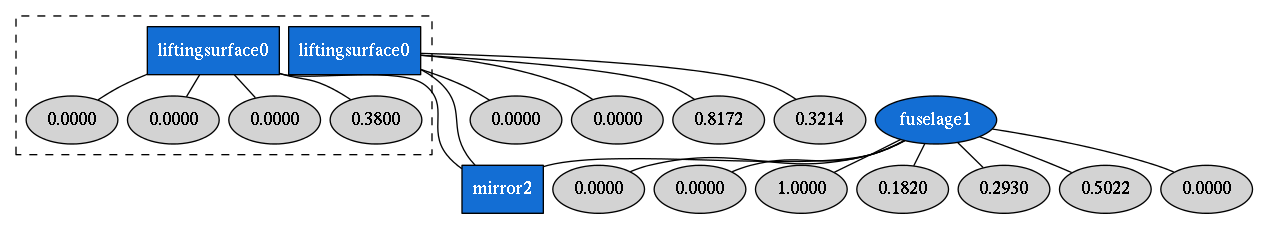

In [19]:
config2.Write('GP_output.step')
graph = config2.pydot_graph()
print(graph.create_dot())
Image(graph.create_png())


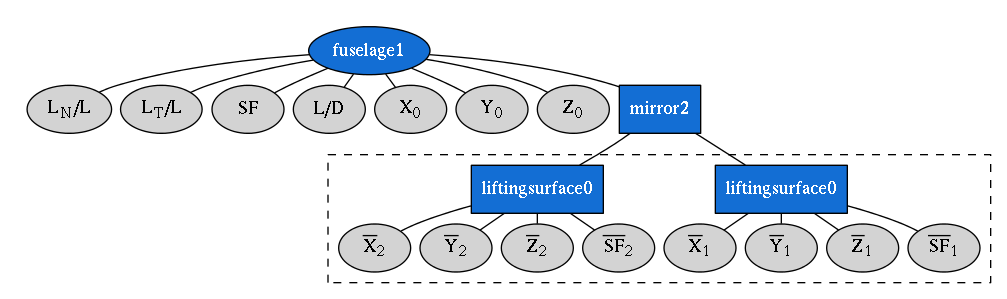

In [20]:
# For now, I'll have to do this by hand...
graph = """digraph G {
ranksep="0.1";
nodesep="0.1";
# splines=ortho;
node [style=filled];
edge [arrowhead=none];
subgraph cluster_standard {
color=invis;
0 [shape=ellipse, fillcolor="#136ed4", label=fuselage1, fontcolor="white"];
1 [shape=ellipse, label=<L<SUB>N</SUB>/L>];
2 [shape=ellipse, label=<L<SUB>T</SUB>/L>];
3 [shape=ellipse, label=<SF>];
4 [shape=ellipse, label="L/D"];
5 [shape=ellipse, label=<X<SUB>0</SUB>>];
6 [shape=ellipse, label=<Y<SUB>0</SUB>>];
7 [shape=ellipse, label=<Z<SUB>0</SUB>>];
8 [shape=box, fillcolor="#136ed4", label="mirror2", fontcolor="white"]
}

subgraph cluster_mirrored {
style=dashed;
9 [shape=box, fillcolor="#136ed4", label=liftingsurface0, fontcolor="white"];
10 [shape=ellipse, label=<<O>X</O><SUB>1</SUB>>];
11 [shape=ellipse, label=<<O>Y</O><SUB>1</SUB>>];
12 [shape=ellipse, label=<<O>Z</O><SUB>1</SUB>>];
13 [shape=ellipse, label=<<O>SF</O><SUB>1</SUB>>];
rank=same;
14 [shape=box, fillcolor="#136ed4", label=liftingsurface0, fontcolor="white"];
15 [shape=ellipse, label=<<O>X</O><SUB>2</SUB>>];
16 [shape=ellipse, label=<<O>Y</O><SUB>2</SUB>>];
17 [shape=ellipse, label=<<O>Z</O><SUB>2</SUB>>];
18 [shape=ellipse, label=<<O>SF</O><SUB>2</SUB>>];
}

0 -> 8;
8-> 9;
8 -> 14;

0 -> 1;
0 -> 2;
0 -> 3;
0 -> 4;
0 -> 5;
0 -> 6;
0 -> 7;
# 0 -> 9;
# 0 -> 14;
9 -> 10;
9 -> 11;
9 -> 12;
9 -> 13;
14 -> 15;
14 -> 16;
14 -> 17;
14 -> 18;

}
"""
dotgraph = pydot.graph_from_dot_data(graph)
Image(dotgraph.create_png())

In [21]:
# dotgraph.write_pdf('/home/pchambers/Documents/PhD/Aviation2017/aviation_2017_paper/figure/gplayout_tree2.pdf')

In [22]:
"""fuselage1(0.182, 0.293, 0.15, 0.5022, 0.10844, 0.2837, 0.4738, mirror2(liftingsurface0(0., 0., 0., 0.38), liftingsurface0(0.8172, 0., 0., 0.3214)))"""

'fuselage1(0.182, 0.293, 0.15, 0.5022, 0.10844, 0.2837, 0.4738, mirror2(liftingsurface0(0., 0., 0., 0.38), liftingsurface0(0.8172, 0., 0., 0.3214)))'

In [23]:
nodes, edges, labels = gp.graph(config2._deap_Tree)

In [24]:
labels

{0: 'fuselage1',
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 1.0,
 5: 0.182,
 6: 0.293,
 7: 0.5022,
 8: 'mirror2',
 9: 'liftingsurface0',
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.38,
 14: 'liftingsurface0',
 15: 0.8172,
 16: 0.0,
 17: 0.0,
 18: 0.3214}

In [25]:
node = config2._deap_Tree[0]

In [26]:
label = 'mirror2'
n = 0

nodetype = label.rstrip('0123456789')
if (nodetype is 'mirror') or (n > 0):
    arity = label.lstrip(nodetype)
    n += int(arity)
    print(arity)

In [27]:
nodetype != 'mirror'

False